In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [35]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [37]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [40]:
# Print column names within the measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [41]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
recent_date[0][0]

'2017-08-23'

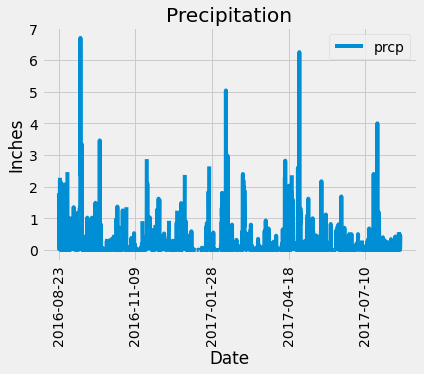

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
string_date = recent_date[0][0].split('-')
year = int(string_date[0])
month = int(string_date[1])
day = int(string_date[2])
first_date =dt.date(year,month,day)
first_date
# Calculate the date one year from the last date in data set.
last_date = first_date - dt.timedelta(days=365)
last_date
# Perform a query to retrieve the data and precipitation scores
twelve_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
pcip_data = pd.DataFrame(twelve_months, columns=['date','prcp'])
pcip_date_data = pcip_data.set_index('date')
# Sort the dataframe by date
pcip_date_data = pcip_date_data.sort_index()
pcip_date_data.head()
# Use Pandas Plotting with Matplotlib to plot the data

pcip_date_data.plot(rot=90)
plt.title('Precipitation')
plt.xlabel("Date")
plt.ylabel('Inches')
plt.legend(loc='best')

In [43]:
import scipy.stats as sts

In [44]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_numpy = np.mean(pcip_date_data)
print(mean_numpy)
median_numpy = np.median(pcip_date_data['prcp'])
print(median_numpy)
mode_scipy = sts.mode(pcip_date_data['prcp'])
print(mode_scipy)
print(sts.normaltest(pcip_date_data.sample(100)))
print(sts.zscore(pcip_date_data))
pcip_date_data['prcp'].describe()

prcp    0.177279
dtype: float64
nan
ModeResult(mode=array([0.]), count=array([874]))
NormaltestResult(statistic=array([nan]), pvalue=array([nan]))
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [51]:
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [97]:
rows = session.query(Measurement.station, Station.station).count()
print(rows)

175950


In [98]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

In [99]:
active = engine.execute('SELECT Measurement.station, Measurement.tobs, Measurement.date FROM Measurement INNER JOIN Station ON Measurement.station = Station.station').fetchall()
active_df = pd.DataFrame(active, columns=['station', 'temp', 'date'])
group_station = active_df.groupby(['station'])
count_station = group_station.count()
count_station.sort_values('temp', ascending=False)

,temp,date
station,,
USC00519281,2772,2772
USC00519397,2724,2724
USC00513117,2709,2709
USC00519523,2669,2669
USC00516128,2612,2612
USC00514830,2202,2202
USC00511918,1979,1979
USC00517948,1372,1372
USC00518838,511,511


In [102]:
most_active_df = active_df[active_df['station'] == 'USC00519281']
most_active_df.head()

,station,temp,date
12187,USC00519281,70.0,2010-01-01
12188,USC00519281,62.0,2010-01-02
12189,USC00519281,74.0,2010-01-03
12190,USC00519281,75.0,2010-01-04
12191,USC00519281,74.0,2010-01-05


In [104]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_df['temp'].describe()

count    2772.000000
mean       71.663781
std         4.357642
min        54.000000
25%        69.000000
50%        72.000000
75%        74.000000
max        85.000000
Name: temp, dtype: float64

In [136]:
pd.to_datetime(most_active_df['date'])
most_active_df['date'].describe()

<ipython-input-136-16e91b806ad0>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  most_active_df['date'].describe()


count                    2772
unique                   2772
top       2012-06-02 00:00:00
freq                        1
first     2010-01-01 00:00:00
last      2017-08-18 00:00:00
Name: date, dtype: object

In [142]:
tweleve_months = most_active_df[most_active_df['date'] >= '2016-08-18']
values = tweleve_months['temp']
values.describe()

count    357.000000
mean      73.196078
std        4.759460
min       59.000000
25%       70.000000
50%       74.000000
75%       77.000000
max       83.000000
Name: temp, dtype: float64

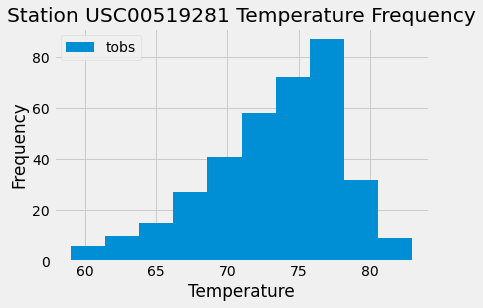

In [144]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.title('Station USC00519281 Temperature Frequency')
plt.xlabel("Temperature")
plt.ylabel('Frequency')
plt.hist(values,label='tobs')
plt.legend(loc='best')
plt.show()

# Close session

In [145]:
# Close Session
session.close()